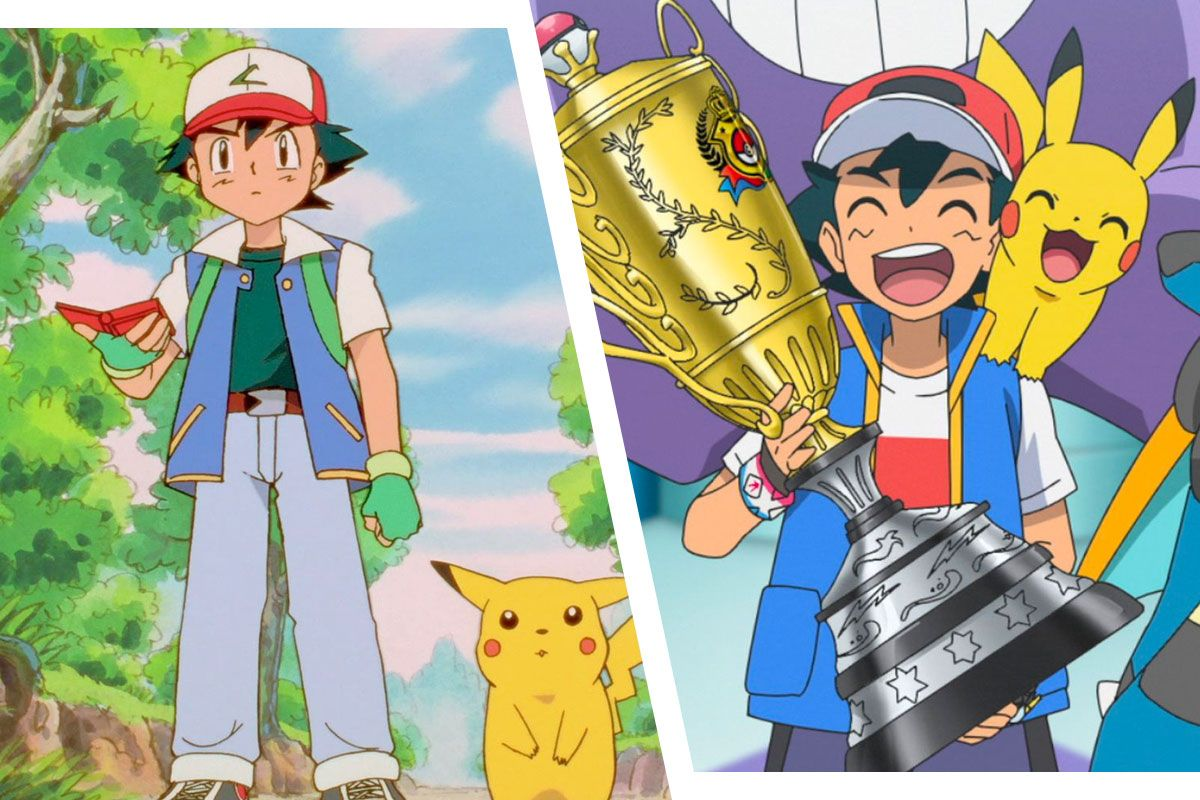

All Pokemon generations (till nowadays)

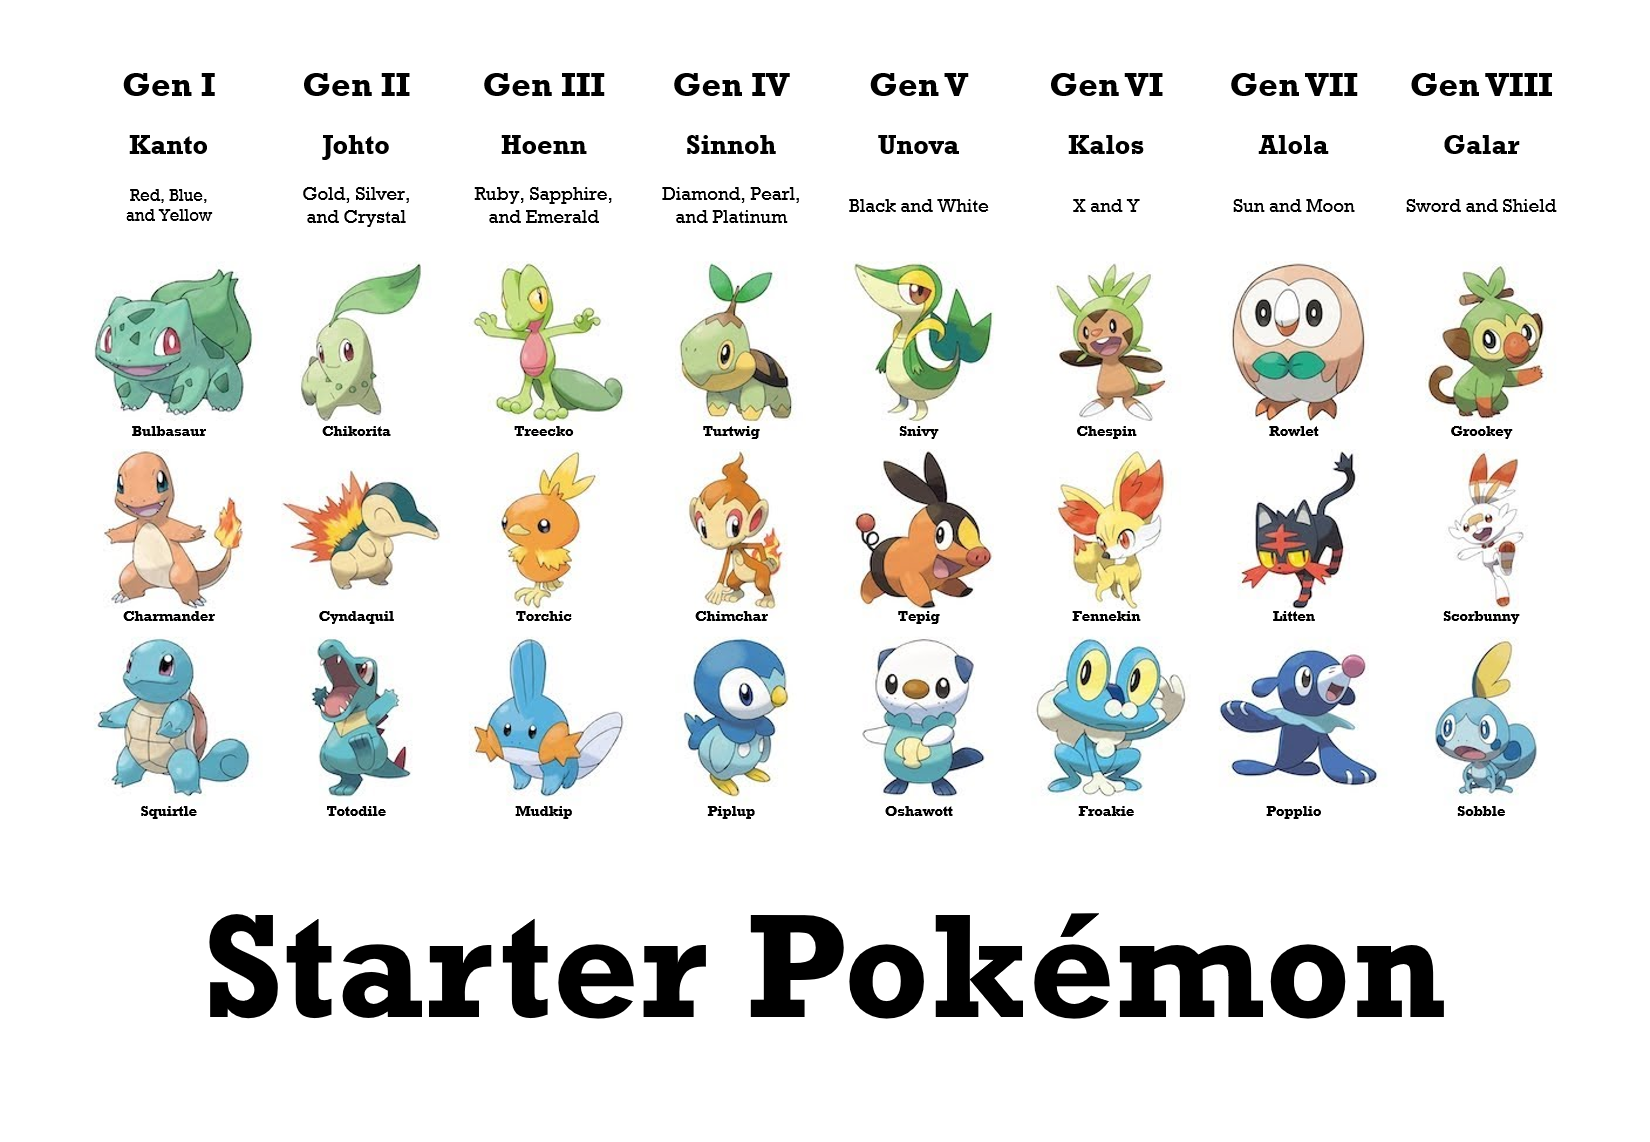

In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import pi
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
pokemon = pd.read_csv("data/pokemon.csv")

# Drop irrelevant columns
pokemon = pokemon.drop(columns=["name", "japanese_name", "abilities", "classfication", "capture_rate"], errors="ignore")

# Fill missing values
pokemon["type2"] = pokemon["type2"].fillna("None")
pokemon["percentage_male"] = pokemon["percentage_male"].fillna(pokemon["percentage_male"].mean())
pokemon["height_m"] = pokemon["height_m"].fillna(pokemon["height_m"].mean())
pokemon["weight_kg"] = pokemon["weight_kg"].fillna(pokemon["weight_kg"].mean())

# Encode types
type1_encoder = LabelEncoder()
type2_encoder = LabelEncoder()
pokemon["type1"] = type1_encoder.fit_transform(pokemon["type1"])
pokemon["type2"] = type2_encoder.fit_transform(pokemon["type2"])


In [4]:
fig = px.histogram(pokemon, x="is_legendary", color="is_legendary",
                   labels={"is_legendary": "Is Legendary"},
                   title="Legendary vs Non-Legendary Count")
fig.show()


In [5]:
corr_matrix = pokemon.corr()
fig = px.imshow(
    corr_matrix,
    title="Feature Correlation Heatmap",
    color_continuous_scale='RdBu_r',
    width=900,    # increase width
    height=700    # increase height
)
fig.show()


In [6]:
fig = px.scatter_matrix(
    pokemon,
    dimensions=['hp', 'attack', 'defense', 'speed'],
    color='is_legendary',
    title="Pairwise Feature Distributions",
    width=900,    # wider
    height=800    # taller
)
fig.show()


In [7]:
legendary_by_type = pokemon.groupby(['type1', 'is_legendary']).size().unstack().fillna(0)
legendary_by_type.index = type1_encoder.inverse_transform(legendary_by_type.index)

fig = go.Figure(data=[
    go.Bar(name='Non-Legendary', x=legendary_by_type.index, y=legendary_by_type[0]),
    go.Bar(name='Legendary', x=legendary_by_type.index, y=legendary_by_type[1])
])
fig.update_layout(barmode='stack', title="Legendary Pokémon by Primary Type",
                  xaxis_title="Primary Type", yaxis_title="Count")
fig.show()


In [8]:
stats = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
avg_stats = pokemon.groupby('is_legendary')[stats].mean()

categories = stats + [stats[0]]

fig = go.Figure()

for is_leg, color in zip([0, 1], ['#1f77b4', '#d62728']):
    values = avg_stats.loc[is_leg].tolist()
    values += values[:1]  # repeat first value
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        name='Legendary' if is_leg == 1 else 'Non-Legendary'
    ))

fig.update_layout(
    polar=dict(radialaxis=dict(visible=True)),
    title="Average Stats Comparison (Radar Chart)",
    showlegend=True
)
fig.show()


In [9]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Height Distribution", "Weight Distribution"))

fig.add_trace(go.Violin(y=pokemon["height_m"], x=pokemon["is_legendary"].astype(str), name="Height",
                        box_visible=True, meanline_visible=True), row=1, col=1)

fig.add_trace(go.Violin(y=pokemon["weight_kg"], x=pokemon["is_legendary"].astype(str), name="Weight",
                        box_visible=True, meanline_visible=True), row=1, col=2)

fig.update_layout(title_text="Height and Weight Distribution by Legendary Status")
fig.show()


In [10]:
X = pokemon.drop(columns=["is_legendary"])
y = pokemon["is_legendary"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, probs))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9751552795031055
ROC AUC Score: 0.9891219891219891

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       143
           1       0.89      0.89      0.89        18

    accuracy                           0.98       161
   macro avg       0.94      0.94      0.94       161
weighted avg       0.98      0.98      0.98       161



In [11]:
# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
fig = px.imshow(cm, text_auto=True, color_continuous_scale='Blues',
                title='Confusion Matrix', labels=dict(x="Predicted", y="Actual"))
fig.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs)
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), showlegend=False))
fig.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
fig.show()


In [12]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(model.coef_[0])
}).sort_values(by='Importance', ascending=False).head(10)

# Force y-axis categories to appear in descending order
fig = px.bar(
    coefficients,
    x='Importance',
    y='Feature',
    orientation='h',
    title='Top 10 Important Features (Descending Order)',
)

fig.update_layout(
    yaxis=dict(categoryorder='total ascending')  # This will display the highest value on top
)
fig.show()


In [14]:
# Filter legendary Pokémon only
legendary_pokemon = pokemon[pokemon["is_legendary"] == 1]

# Assuming 'base_total' is the stat representing overall strength; if not present, use sum of stats
if "base_total" in legendary_pokemon.columns:
    top10_legendary = legendary_pokemon.nlargest(10, "base_total")
else:
    stats_cols = ['hp', 'attack', 'defense', 'sp_attack', 'sp_defense', 'speed']
    legendary_pokemon["total_stats"] = legendary_pokemon[stats_cols].sum(axis=1)
    top10_legendary = legendary_pokemon.nlargest(10, "total_stats")

# If you dropped the 'name' column, you won't have names to show, so reload names for this part:
pokemon_names = pd.read_csv("data/pokemon.csv")[["pokedex_number", "name"]]

# Merge to get names for the top 10
top10_legendary = top10_legendary.merge(pokemon_names, on="pokedex_number", how="left")

# Plot top 10 legendary Pokémon by their base_total
fig = px.bar(
    top10_legendary,
    x='name',
    y='base_total' if "base_total" in top10_legendary.columns else 'total_stats',
    title='Top 10 Legendary Pokémon by Total Stats',
    labels={'name': 'Pokémon', 'base_total': 'Base Total Stats', 'total_stats': 'Total Stats'},
    color='base_total' if "base_total" in top10_legendary.columns else 'total_stats',
    color_continuous_scale='Viridis'
)
fig.update_layout(xaxis_tickangle=-45, width=900, height=600)
fig.show()


In [15]:
if 'generation' in pokemon.columns:
    fig = px.histogram(pokemon, x='generation', color='is_legendary',
                       barmode='group', title='Legendary Pokémon by Generation')
    fig.show()
else:
    print("Column 'generation' not found.")


In [17]:
new_pokemon_dict = {
    'against_bug': 1.0,
    'against_dark': 1.0,
    'against_dragon': 2.0,
    'against_electric': 1.0,
    'against_fairy': 0.5,
    'against_fight': 1.0,
    'against_fire': 0.5,
    'against_flying': 2.0,
    'against_ghost': 1.0,
    'against_grass': 0.5,
    'against_ground': 1.0,
    'against_ice': 1.0,
    'against_normal': 1.0,
    'against_poison': 1.0,
    'against_psychic': 1.0,
    'against_rock': 1.0,
    'against_steel': 0.5,
    'against_water': 1.0,
    'attack': 120,
    'base_egg_steps': 5120,
    'base_happiness': 70,
    'base_total': 655,
    'defense': 90,
    'experience_growth': 1250000,
    'height_m': 2.5,
    'hp': 100,
    'percentage_male': 50.0,
    'pokedex_number': 999,
    'sp_attack': 150,
    'sp_defense': 100,
    'speed': 95,
    'type1': type1_encoder.transform(['dragon'])[0],
    'type2': type2_encoder.transform(['None'])[0],
    'weight_kg': 200.0,
    'generation': 8,
}
# Convert to DataFrame
new_pokemon_df = pd.DataFrame([new_pokemon_dict])

# Scale using the same scaler used in training
new_pokemon_scaled = scaler.transform(new_pokemon_df)

# Make prediction
prediction = model.predict(new_pokemon_scaled)[0]
print("🧬 Is the Pokémon Legendary?", "Yes" if prediction == 1 else "No")

probability = model.predict_proba(new_pokemon_scaled)[0][1]
print("Probability of being Legendary:", probability)

🧬 Is the Pokémon Legendary? No
Probability of being Legendary: 0.1460959134422008


In [ ]:
###########################################################******+++++++++++++++
##########################################################**+++============+++++
##########################################################**+++++++++++++++++++*
##########################################################***++++++++++++++*****
###########################################################*++++++++++++++******
###########################################################**+++++++++++++******
###########################################################**++++++++++++*******
###########################################################****++++++++++*******
####%%%#####################################################****+++++++*********
#####%##%#++**####*##########################################*******************
####*#%%%*=====+*#############################################******************
###****#%#========++*##########################################################*
###*****##============+*###################################################*++==
##*******#*==============+*###########################################**+=======
##********#*================+#####################################*++===========                          Thank You
############+=================+*#############################**+================
#############*==================+###***********************+====================
###############+================================================================
#########%%#%#%#*==============================================================+
######%%%%%%%%%#%#+==========================================================+*#
####%%%%%%%%%%%###%#+==++==================================================+*#**
#%%%%%%%%%%%%%####%%%#+=============================================++==+**#****
#%%%%%%%%%%%%######%%*================================================+##*******
#%%%%%%%%%%#######%%*=========+++=======================+++============+#*******
#%%%%%%%%%%#########========++=+%#=====================+==#%*===========+#******
#%%%%%%%%%%%#######+========#*=*%%*===================+#++#%#============*#*****
#%%%%%%%%%%%#####%*=========+%%%%#=====================#%%%#*============+#**###
#%%%%%%%%%%%######============+++=======================+++===============*#####
#%%%%%%%%%%%%###%+======================*###+==============================#####
#%%%%%%%%%%%#####==++***++====================================++***++======*%###
#%%%%%%%########*=********+=================================+*********======####
################+=********+=============+++++++++===========+*********+=====*###
###########****#+==+*****+=============*+======+*+===========+*******+=======###
#**************#*=====================+*========+*==============+++==========*#*
#***************#+=====================+*+======+*============================#*
#****************#+======================++++++++=============================*#
#*****************#+==========================================================+#
#******************#+==========================================================#
#******************##+=========================================================*
#####################+=========================================================+